# 📑 **Table of Contents**  

### **1. [Missing Salary Imputation](#1-missing-salary-imputation)**  
- Imputing missing salary values using the median to maintain data consistency.  

### **2. [Duplicate Employee ID Check](#2-duplicate-employee-id-check)**  
- Ensuring employee IDs are unique to avoid calculation distortions.  

### **3. [Performance Score Conversion](#3-performance-score-conversion)**  
- Converting performance scores to integer format for accurate analysis.  

### **4. [Date Format Standardization](#4-date-format-standardization)**  
- Standardizing dates to YYYY-MM-DD format for consistency and trend analysis.  

### **5. [Department Typo Correction](#5-department-typo-correction)**  
- Fixing typos to ensure accurate aggregation and reporting.  

### **6. [Salary Outlier Removal](#6-salary-outlier-removal)**  
- Removing extreme salary values to prevent skewed statistical analysis.  

### **7. [Email Domain Extraction](#7-email-domain-extraction)**  
- Extracting email domains for better grouping and categorization.  

### **8. [Salary Correlation Calculation](#8-salary-correlation-calculation)**  
- Calculating the correlation between salary and other key factors.  

### **9. [Average Salary Aggregation](#9-average-salary-aggregation)**  
- Aggregating average salary per department and job level for insights.  

### **10. [Duplicate Row Removal](#1-duplicate-row-removal)**   
- Removing duplicate rows to ensure data integrity and accuracy.  


> **📌 NOTE:** The above operations are performed based on the specific requirements of the dataset, not necessarily in the order listed.  
> For example, **duplicate rows or IDs** should be removed **before imputing missing values** to avoid interference in statistical calculations.  
> However, **all operations** mentioned are comprehensively covered in this notebook.  


### Import Libraries

In [40]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os


### Importing files

In [41]:
df=pd.read_csv("/content/empd.csv")
df.head()

,employee_id,first_name,last_name,email,phone,department,job_title,salary,join_date,performance_score
0,EMP0001,Robert,Vasquez,anthonyhubbard@example.com,395-797-9647,HR,Senior Analyst,89934.0,2022-09-06,5.0
1,EMP0002,Barbara,Bruce,bonniethomas@example.com,001-745-858-7716x94722,HR,Senior Consultant,77234.0,2024-07-05,5.0
2,EMP0003,Derek,Martin,smiller@example.net,356-450-4481x832,Enginering,Senior Consultant,92953.0,2022-11-02,3.0
3,EMP0004,Monique,Serrano,joseph51@example.net,001-852-702-8457,Sales,Senior Engineer,110460.0,2024-09-21,NaN
4,EMP0005,Frank,Robinson,mariepope@example.net,+1-788-681-6711x207,HR,Manager Manager,75316.0,2023-07-29,2.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   employee_id        1260 non-null   object 
 1   first_name         1100 non-null   object 
 2   last_name          1208 non-null   object 
 3   email              1149 non-null   object 
 4   phone              1260 non-null   object 
 5   department         1260 non-null   object 
 6   job_title          1260 non-null   object 
 7   salary             1125 non-null   float64
 8   join_date          1150 non-null   object 
 9   performance_score  1133 non-null   float64
dtypes: float64(2), object(8)
memory usage: 98.6+ KB


In [43]:
df.isna().sum()

,0
employee_id,0
first_name,160
last_name,52
email,111
phone,0
department,0
job_title,0
salary,135
join_date,110
performance_score,127


# 🗑️ **1. Duplicate Row Removal**  
**Reason:**  
- Removing duplicate rows is the first and most crucial step because they can distort subsequent calculations and analysis, including:  
   - **Aggregations** – Incorrect sum, mean, or median values  
   - **Correlations** – Skewed relationship insights  
   - **Imputation** – Inaccurate filling of missing values  

> 👉 Removing duplicates ensures accurate statistical analysis and reliable insights.  

In [44]:
# Remove duplicate rows considering all columns
df = df.drop_duplicates()

# Verify if there are any remaining duplicate rows
if df.duplicated().any():
    print("There are still duplicate rows.")
else:
    print("Duplicates were successfully removed.")

Duplicates were successfully removed.


# 🆔 **Duplicate Employee ID Check**  
**Reason:**  
- After removing general duplicates, it's critical to ensure that there are no duplicate `employee_id` values, as they can distort key metrics:  
   - **Average Salary** – Overestimated or underestimated  
   - **Performance Scores** – Incorrect assessment of employee performance  
   - **Correlations** – Skewed relationships with other variables  

> 👉 Resolving duplicate employee IDs ensures data integrity and accurate calculations.  


In [45]:
df.shape

(1225, 10)

In [46]:
unique_count = df['employee_id'].nunique()
print("Total Unique employee are :",unique_count)


Total Unique employee are : 1200


In [47]:

# Identify employee_id values that appear more than once
duplicate_employee_ids = df['employee_id'].value_counts()[df['employee_id'].value_counts() > 1].index

# Print the duplicate employee_id values
print("Duplicate employee_ids:", duplicate_employee_ids)

Duplicate employee_ids: Index(['EMP0745', 'EMP1061', 'EMP0635', 'EMP0579', 'EMP0135', 'EMP0275',
       'EMP0271', 'EMP0346', 'EMP0468', 'EMP0054', 'EMP0718', 'EMP0802',
       'EMP0247', 'EMP0103', 'EMP0379', 'EMP0699', 'EMP0979', 'EMP0487',
       'EMP0750', 'EMP0018', 'EMP0347', 'EMP0458', 'EMP0306', 'EMP0595',
       'EMP0150'],
      dtype='object', name='employee_id')


In [48]:
# Remove second and further occurrences of duplicate employee_id values, keeping the first
df = df[~df.duplicated(subset='employee_id', keep='first')]

In [49]:
df.shape

(1200, 10)

# 🏢 **Department Typo Correction**  
**Reason:**  
- Inconsistent department names can cause misgrouping during analysis, affecting:  
   - **Average Salary Per Department** – Incorrect grouping  
   - **Aggregations** – Misleading statistics  

✏️ Correcting typos ensures consistent grouping and accurate reporting.  


In [50]:
df["department"].unique()

array(['HR', 'Enginering', 'Sales', 'IT', 'Marketing', 'Finance',
       'Operations', 'Engineering', 'Marketting'], dtype=object)

In [51]:
department_corrections = {
    'Enginering': 'Engineering',
    'Marketting': 'Marketing',
}
df['department'] = df['department'].replace(department_corrections)

# 📊 **Performance Score Conversion**  
**Reason:**  
- The `performance_score` column must be numeric for accurate analysis:  
   - **Statistical Operations** – Mean, median, and correlation require numeric values  
   - **Data Integrity** – Avoids errors during analysis  

🔢 Convert non-numeric values to **-1** to maintain consistency and prevent calculation errors.  


In [52]:
# Convert performance_score to numeric, coercing errors to NaN
df['performance_score'] = pd.to_numeric(df['performance_score'], errors='coerce')

# Replace None (NaN) values with -1
df['performance_score'].fillna(-1, inplace=True)

# Convert the column to integer type
df['performance_score'] = df['performance_score'].astype(int)

df.head()

<ipython-input-52-087c3343c607>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['performance_score'].fillna(-1, inplace=True)


,employee_id,first_name,last_name,email,phone,department,job_title,salary,join_date,performance_score
0,EMP0001,Robert,Vasquez,anthonyhubbard@example.com,395-797-9647,HR,Senior Analyst,89934.0,2022-09-06,5
1,EMP0002,Barbara,Bruce,bonniethomas@example.com,001-745-858-7716x94722,HR,Senior Consultant,77234.0,2024-07-05,5
2,EMP0003,Derek,Martin,smiller@example.net,356-450-4481x832,Engineering,Senior Consultant,92953.0,2022-11-02,3
3,EMP0004,Monique,Serrano,joseph51@example.net,001-852-702-8457,Sales,Senior Engineer,110460.0,2024-09-21,-1
4,EMP0005,Frank,Robinson,mariepope@example.net,+1-788-681-6711x207,HR,Manager Manager,75316.0,2023-07-29,2


# 📆 **Date Format Standardization**  
**Reason:**  
- A consistent date format (`YYYY-MM-DD`) is essential for:  
   - **Time-Based Analysis** – Accurate correlation and trend analysis  
   - **Join Year Extraction** – Helps in analyzing salary trends over time  

📅 Handle conversion errors gracefully to maintain data integrity.  


In [53]:
def convert_join_date(row):
    try:
        # Convert join_date to datetime format
        return pd.to_datetime(row, errors='raise').strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Error converting '{row}' to date: {e}")
        return None  # Return None if conversion fails

# Apply the function to the join_date column
df['join_date'] = df['join_date'].apply(convert_join_date)

# Create a new 'join_year' column from the converted 'join_date' column
df['join_year'] = pd.to_datetime(df['join_date'], errors='coerce').dt.year

Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error conv

<ipython-input-53-cbb0be36cbc0>:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(row, errors='raise').strftime('%Y-%m-%d')


Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error converting 'nan' to date: NaTType does not support strftime
Error conv

# 📉 **Missing Salary Imputation**  
**Reason:**  
- Missing salary values can interfere with salary-based calculations, such as:  
   - **Average Salary** – Incomplete or biased  
   - **Correlations** – Distorted relationships with other factors  

✅ Impute missing salary values using the **median salary per department** to ensure consistent and unbiased analysis.  


In [54]:
# Calculate the median salary for each department and fill missing salary values
df['salary'] = df.groupby('department')['salary'].transform(lambda x: x.fillna(x.median()))

# 🚨 **Salary Outlier Removal**  
**Reason:**  
- Outliers can significantly distort statistical measures:  
   - **Average Salary** – Extreme values skew the mean  
   - **Correlation and Trend Analysis** – Misleading relationships  

🚫 Remove outliers more than **3 standard deviations** from the mean to improve data quality and representativeness.  


In [55]:
# Calculate the mean and standard deviation of the salary column
mean_salary = df['salary'].mean()
std_salary = df['salary'].std()

# Calculate the lower and upper bounds for salary (mean ± 3 * std)
lower_bound = mean_salary - 3 * std_salary
upper_bound = mean_salary + 3 * std_salary

# Filter out rows where the salary is more than 3 standard deviations from the mean
df_cleaned = df[(df['salary'] >= lower_bound) & (df['salary'] <= upper_bound)]

# Print the cleaned DataFrame
print(f"Mean Salary: {mean_salary}")
print(f"Standard Deviation of Salary: {std_salary}")


Mean Salary: 80617.14833333333
Standard Deviation of Salary: 18538.093635431527


# 📧 **Email Domain Extraction**  
**Reason:**  
- Extracting the email domain can be useful for:  
   - **Categorization** – Grouping employees by organization or department  
   - **Missing or Invalid Emails** – Assign `None` to incomplete or invalid email addresses  

📤 This step enhances data completeness but is not essential for core statistical analysis.  


In [56]:
# Function to extract domain from the email address
def extract_domain(email):
    if pd.isna(email) or '@' not in email:
        return None  # Return None for invalid or missing email addresses
    return email.split('@')[-1]  # Extract domain part after '@'

# Apply the function to the 'email' column to create the 'email_domain' column
df['email_domain'] = df['email'].apply(extract_domain)


# 🔗 **Salary Correlation Calculation**  
**Reason:**  
- Once the data is clean, you can accurately calculate the correlation between:  
   - **Salary**  
   - **Join Year**  

📈 This reveals how salary trends over time, providing valuable business insights.

In [57]:
# Convert 'join_year' to numeric if it isn't already
df['join_year'] = pd.to_numeric(df['join_year'], errors='coerce')

# Drop rows where salary or join_year is NaN to avoid issues with correlation calculation
df_cleaned = df.dropna(subset=['salary', 'join_year'])

# Check if there are enough data points to calculate correlation
if len(df_cleaned) > 1:
    # Calculate Pearson correlation coefficient between 'salary' and 'join_year'
    correlation, _ = pearsonr(df_cleaned['salary'], df_cleaned['join_year'])
    print(f"Pearson correlation coefficient: {correlation}")
else:
    print("Insufficient data to calculate correlation.")

Pearson correlation coefficient: -0.0034876559660849335


# 📊 **Average Salary Aggregation**  
**Reason:**  
- Final aggregation should be done after data cleaning and imputation to ensure accuracy:  
   - **Average Salary Per Department** – Reliable department-level insights  
   - **Job Level Insights** – Consistent performance evaluation

In [58]:
# Create a pivot table to calculate average salary per department and job_level
pivot_table = df.pivot_table(values='salary', index='department', columns='job_title', aggfunc='mean')

# Print the pivot table
print(pivot_table)

job_title    Director Analyst  Director Consultant  Director Engineer  \
department                                                              
Engineering      84576.266667         86662.333333       78999.500000   
Finance          84758.833333         85511.500000       84410.100000   
HR               81703.333333         83198.125000       75731.333333   
IT               74393.083333         89941.888889       75353.687500   
Marketing        76284.222222         76723.181818       78920.400000   
Operations       83082.375000         88438.000000       84910.333333   
Sales            75914.571429         78900.454545       73967.875000   

job_title    Director Manager  Junior Analyst  Junior Consultant  \
department                                                         
Engineering      88038.125000    74566.833333       89315.000000   
Finance          84374.333333    81860.611111       89897.833333   
HR               74284.454545    77661.111111       84381.250000   
IT

In [59]:
df.head()

,employee_id,first_name,last_name,email,phone,department,job_title,salary,join_date,performance_score,join_year,email_domain
0,EMP0001,Robert,Vasquez,anthonyhubbard@example.com,395-797-9647,HR,Senior Analyst,89934.0,2022-09-06,5,2022.0,example.com
1,EMP0002,Barbara,Bruce,bonniethomas@example.com,001-745-858-7716x94722,HR,Senior Consultant,77234.0,2024-07-05,5,2024.0,example.com
2,EMP0003,Derek,Martin,smiller@example.net,356-450-4481x832,Engineering,Senior Consultant,92953.0,2022-11-02,3,2022.0,example.net
3,EMP0004,Monique,Serrano,joseph51@example.net,001-852-702-8457,Sales,Senior Engineer,110460.0,2024-09-21,-1,2024.0,example.net
4,EMP0005,Frank,Robinson,mariepope@example.net,+1-788-681-6711x207,HR,Manager Manager,75316.0,2023-07-29,2,2023.0,example.net


# Additional Advanced Analysis and Predictive Insights for Employee Optimization

# ✅ **Data Validation Checks**  
**Reason:**
- Demonstrates attention to detail and ensures the data makes sense, not just that it’s clean.  
- Ensures that the data is logically consistent and falls within expected boundaries.  
- Validating salary ranges and logical join dates prevents anomalies that could distort analysis.  



In [60]:
# Check if salary is within a reasonable range for each department
salary_min_max = df.groupby('department')['salary'].agg(['min', 'max'])
print(salary_min_max)


                 min       max
department                    
Engineering  38651.0  131201.0
Finance      26980.0  157054.0
HR           15174.0  129106.0
IT           38361.0  141577.0
Marketing    35777.0  134403.0
Operations   40248.0  132647.0
Sales        30567.0  123809.0


In [61]:
df['job_title'].unique()

array(['Senior Analyst', 'Senior Consultant', 'Senior Engineer',
       'Manager Manager', 'Junior Consultant', 'Lead Engineer',
       'Director Engineer', 'Lead Consultant', 'Junior Analyst',
       'Director Manager', 'Director Consultant', 'Manager Engineer',
       'Manager Analyst', 'Junior Engineer', 'Director Analyst',
       'Senior Manager', 'Junior Manager', 'Lead Manager',
       'Manager Consultant', 'Lead Analyst'], dtype=object)

# 📊 **Correlation Between Performance Score and Salary**  
**Reason:**  
- Helps identify if higher performance scores are linked to higher salaries.  
- Understanding this correlation can reveal whether performance-based incentives are effectively implemented.  
- Provides insights into potential salary adjustments to align with performance.  


In [62]:
# Drop rows where salary or performance_score is NaN to avoid issues with correlation calculation
df_cleaned = df.dropna(subset=['salary', 'performance_score'])

# Check if there are enough data points to calculate correlation
if len(df_cleaned) > 1:
    # Calculate Pearson correlation coefficient between 'salary' and 'join_year'
    correlation, _ = pearsonr(df_cleaned['salary'], df_cleaned['performance_score'])
    print(f"Pearson correlation coefficient: {correlation}")
else:
    print("Insufficient data to calculate correlation.")

Pearson correlation coefficient: 0.014462836932214052


### 🚀 Performance Score shows a stronger correlation with Salary than with Join Year!

# 🔍 **Clustering for Employee Segmentation (K-means Clustering)**  
**Reason:**  
- Helps segment employees into distinct groups based on factors like **salary**, **job level**, **performance score**, and **tenure**.  
- Identifies patterns such as **high-performing employees**, **underpaid employees**, or **employees at risk of leaving**.  
- Demonstrates the ability to apply **unsupervised learning** to uncover hidden insights and support data-driven decisions.  


In [63]:
import pandas as pd

# Define your mapping function
def assign_job_level(job_title):
    if 'Junior' in job_title:
        return 'Junior'
    elif 'Lead' in job_title:
        return 'Lead'
    elif 'Senior' in job_title:
        return 'Senior'
    elif 'Manager' in job_title:
        return 'Manager'
    elif 'Director' in job_title:
        return 'Director'
    return 'Other'  # For any other cases

# Assuming you already have the DataFrame 'df'
df['job_level'] = df['job_title'].apply(assign_job_level)

# Check the result
print(df[['job_title', 'job_level']].head())


           job_title job_level
0     Senior Analyst    Senior
1  Senior Consultant    Senior
2  Senior Consultant    Senior
3    Senior Engineer    Senior
4    Manager Manager   Manager


In [64]:
import pandas as pd

# Define the mapping function
def assign_job_level_num(job_title):
    if 'Junior' in job_title:
        return 0
    elif 'Lead' in job_title:
        return 1
    elif 'Senior' in job_title:
        return 2
    elif 'Manager' in job_title:
        return 3
    elif 'Director' in job_title:
        return 4
    return -1  # In case there is an unexpected job title

# Assuming your DataFrame is named df
df['job_level_num'] = df['job_title'].apply(assign_job_level_num)

# Check the result
print(df[['job_title', 'job_level_num']].head())


           job_title  job_level_num
0     Senior Analyst              2
1  Senior Consultant              2
2  Senior Consultant              2
3    Senior Engineer              2
4    Manager Manager              3


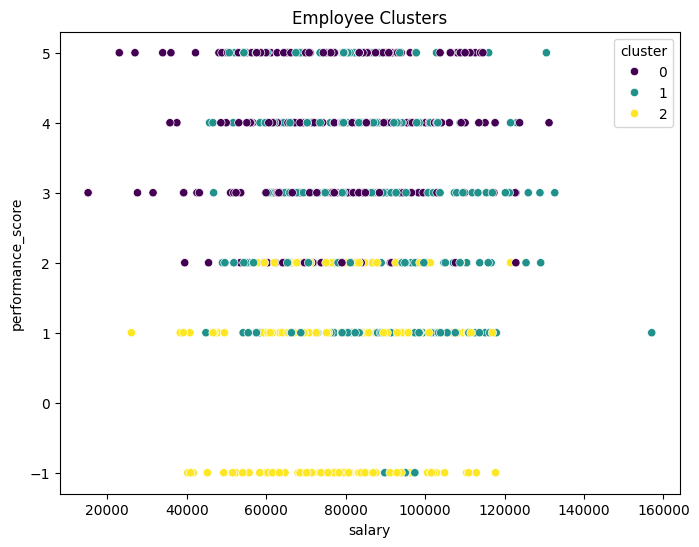

In [66]:
df['tenure_years'] = 2025 - df['join_year']

# Drop rows with missing values
df = df.dropna()

# Select features for clustering
features = df[['salary', 'performance_score', 'tenure_years', 'job_level_num']]

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering with fixed number of threads
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='salary', y='performance_score', hue='cluster', data=df, palette='viridis')
plt.title('Employee Clusters')
plt.show()


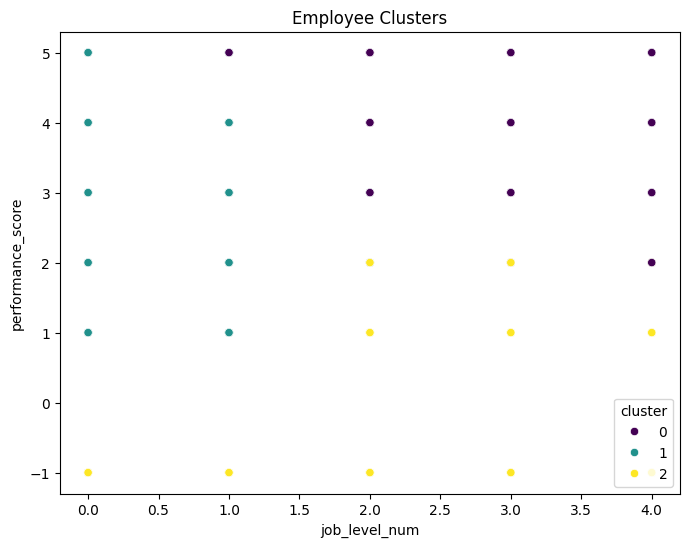

In [67]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(y='performance_score', x='job_level_num', hue='cluster', data=df, palette='viridis')
plt.title('Employee Clusters')
plt.show()

# 🏁 **Conclusion**  
- 🟡 The **yellow cluster** primarily consists of employees with **job level ≥ 2** (Senior or above position)and it is not able to cross more than 2 as performance level.
- 🟢 The **green cluster** shows a **wide variation** in **performance scores**.  
- 🟣 The **dark violet cluster** mainly includes employees with **job level ≥ 3** (manager or above position)with the performance score ≥ 3
